#**SUMMARY**

Filename    : model.ipynb   
Description : The file contains logic for creating model

Below steps were performed for data preparation,   
      1.   Building a pneumonia detection model starting from basic CNN and then   improving upon it.   
      2.   Train the model     
      3.   To deal with large training time, save the weights so that you can use them when training the model for the second time without starting from scratch.   


**Revision History**  
Date        ||       Description               ||              Author  
07-06-2020   ||   Initial logic for model creation   ||   Arvindh   
  



#**Import Libraries**

In [0]:
%tensorflow_version 2.x

In [2]:
import tensorflow
tensorflow.__version__

'2.2.0'

In [3]:
import pandas as pd 
import numpy as np
from seaborn import countplot
from matplotlib.pyplot import figure, show
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
!pip3 install pydicom
import pydicom
import os
from skimage.transform import resize
import keras
import pandas as pd
import pickle
import cv2

     |████████████████████████████████| 35.5MB 1.3MB/s 


Using TensorFlow backend.


In [0]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#Mount Google Drive

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Set your project path 
project_path =  'drive/My Drive/Colab Notebooks/Capstone'
train_img_path = 'drive/My Drive/Colab Notebooks/Capstone/dataset/stage_2_train_images'
valid_img_path = 'drive/My Drive/Colab Notebooks/Capstone/dataset/stage_2_train_images'
test_img_path = 'drive/My Drive/Colab Notebooks/Capstone/dataset/stage_2_test_images'

In [0]:
train_df_pick = "/train_df_pickle"
valid_df_pick = "/valid_df_pickle"

# we open the file for reading
fileObject = open(project_path+train_df_pick,'rb')  
fileObject1 = open(project_path+valid_df_pick,'rb')  

# load the object from the file into temp var b
train_df = pickle.load(fileObject)  
valid_df = pickle.load(fileObject1) 

In [9]:
train_patient_Ids = train_df.patientId.unique()
print("The number of unique patient id in the training dataset is "+ str(train_patient_Ids.shape[0]))

The number of unique patient id in the training dataset is 21908


In [10]:
valid_patient_Ids = valid_df.patientId.unique()
print("The number of unique patient id in the validation dataset is "+ str(valid_patient_Ids.shape[0]))

The number of unique patient id in the validation dataset is 5914


#Custom Data generator

In [0]:
class Generator(keras.utils.Sequence):
  def __init__(self, unique_patient_ids, folder, dataframe, batch_size=100, shuffle=False, image_size=256, predict=False):
        self.unique_patient_ids = unique_patient_ids
        self.folder = folder
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_size = image_size
        self.predict = predict
        self.on_epoch_end()
   
  def __load__(self, pat_id):
        patIdWithExt = pat_id+'.dcm'
        # load dicom file from pixel array
        img = pydicom.dcmread(os.path.join(self.folder, patIdWithExt)).pixel_array
        # create empty array
        msk = np.zeros(img.shape) 
        
        if pat_id in self.dataframe["patientId"].values:
            pat_info = self.dataframe[self.dataframe.patientId == pat_id]

            # loop through patient rows in the df
            for info in pat_info.iterrows():
                row = info[1]
                if row.Target == 1:
                    x = int(row.x)
                    y = int(row.y)
                    msk[y: int(row.y) + int(row.height), x: int(row.x) + int(row.width)] = 1 
      
        img = cv2.resize(img, (self.image_size, self.image_size))
        msk = cv2.resize(msk, (self.image_size, self.image_size))
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)   

        #img2 = np.concatenate((img,)*3, axis=-1) 
        #msk2 = np.concatenate((msk,)*3, axis=-1)
        return img, msk

  def __loadpredict__(self, pat_id):
        patIdWithExt = pat_id
        # load dicom file from pixel array
        img = pydicom.dcmread(os.path.join(self.folder, patIdWithExt)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img

  def __getitem__(self, index):
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(pat_id_row) for pat_id_row in self.unique_patient_ids]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, self.unique_patient_ids
        else:    
            # select pat_ids by batches
            batch_pat_ids = self.unique_patient_ids[index*self.batch_size : (index+1)*self.batch_size]

            # load pat ids by loop
            items = [self.__load__(pat_id_row) for pat_id_row in batch_pat_ids]
            imgs, msks = zip(*items)

            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
        return imgs, msks

  def __len__(self):
        if self.predict:
            return int(np.ceil(len(self.unique_patient_ids) / self.batch_size))
        else:
            # __len__ provides number of batches per epoch
            return int(np.floor(self.unique_patient_ids.shape[0] / self.batch_size))

  def on_epoch_end(self):
        if self.predict:
            self.indexes = np.arange(len(self.unique_patient_ids))
        else:
            self.indexes = np.arange(self.unique_patient_ids.shape[0])
        if self.shuffle == True:
              np.random.shuffle(self.indexes)

In [0]:
#To be used finally
#train_gen = Generator(train_patient_Ids, train_img_path, train_df, batch_size=32, shuffle=False, image_size=256)
#valid_gen = Generator(valid_patient_Ids, valid_img_path, valid_df, batch_size=32, shuffle=False, image_size=256)

In [0]:
train_gen = Generator(train_patient_Ids[:500], train_img_path, train_df, batch_size=100, shuffle=False, image_size=256)
valid_gen = Generator(valid_patient_Ids[:250], valid_img_path, valid_df, batch_size=100, shuffle=False, image_size=256)

In [0]:
def create_downsample(filters, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_cnn_model(input_size):
  inputs = keras.Input(shape=(input_size, input_size, 1))
  x = keras.layers.Conv2D(32, 3, padding='same', use_bias=False)(inputs)

  filters = 32
  for d in range(4):
        filters = filters * 2
        x = create_downsample(filters, x)
  
  x = keras.layers.BatchNormalization(momentum=0.9)(x)
  x = keras.layers.LeakyReLU(0)(x)
  x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
  outputs = keras.layers.UpSampling2D(2**4)(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

In [25]:
model = create_cnn_model(input_size=256)
model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("model_1.h5", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="auto", period=1)
stop = EarlyStopping(monitor="val_loss", patience=10, mode="auto")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="auto")
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 256, 256, 32)      288       
_________________________________________________________________
batch_normalization_16 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 256, 64)      18432     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 128, 128, 64)      256 

In [26]:
history = model.fit_generator(train_gen, 
                              validation_data=valid_gen, 
                              callbacks=[checkpoint, reduce_lr, stop],
                              epochs=4, 
                              workers=1, 
                              use_multiprocessing=False)

Epoch 1/4


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


5/5 [==============================] - 438s 88s/step - loss: 0.5004 - accuracy: 0.8080 - val_loss: 0.2044 - val_accuracy: 0.9555

Epoch 00001: val_loss improved from inf to 0.20439, saving model to model_1.h5
Epoch 2/4
5/5 [==============================] - 356s 71s/step - loss: 0.1901 - accuracy: 0.9554 - val_loss: 0.1658 - val_accuracy: 0.9700

Epoch 00002: val_loss improved from 0.20439 to 0.16582, saving model to model_1.h5
Epoch 3/4
5/5 [==============================] - 348s 70s/step - loss: 0.1567 - accuracy: 0.9573 - val_loss: 0.1367 - val_accuracy: 0.9724

Epoch 00003: val_loss improved from 0.16582 to 0.13674, saving model to model_1.h5
Epoch 4/4
5/5 [==============================] - 344s 69s/step - loss: 0.1470 - accuracy: 0.9577 - val_loss: 0.1149 - val_accuracy: 0.9725

Epoch 00004: val_loss improved from 0.13674 to 0.11488, saving model to model_1.h5


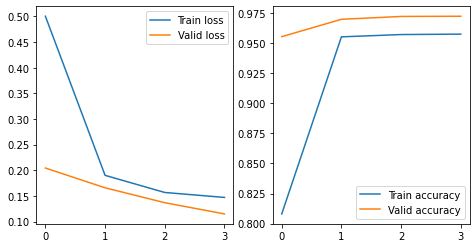

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.show()

In [28]:
test_filenames = os.listdir(test_img_path)
print('n test samples:', len(test_filenames))

n test samples: 3000


In [33]:
len(test_filenames[:2])

2

#Test dataset

In [0]:
test_gen = Generator(test_filenames[:100], test_img_path, valid_df, batch_size=100, shuffle=False, image_size=256, predict=True)

In [40]:
pred = model.predict(test_gen)

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


In [58]:
pred[2]

array([[0.00461602],
       [0.00461602],
       [0.00461602],
       ...,
       [0.00488329],
       [0.00488329],
       [0.00488329]], dtype=float32)